In [1]:
import time

import rasterio

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pystac_client 
import planetary_computer as pc

import dask
import dask_gateway
import dask.array as da
from dask.distributed import Client

Useful examples:
https://examples.dask.org/applications/image-processing.html

API documentation:
https://docs.dask.org/en/stable/array-api.html

Dask array examples:
https://docs.dask.org/en/latest/array.html

## Open NAIP scene

In [2]:
URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = pystac_client.Client.open(URL)

itemid = 'ca_m_3412037_nw_10_060_20180913_20190208',  # dangermond
search = catalog.search(
    collections=["naip"],
    ids = itemid)

item = list(search.get_items())[0]
# sign and open item
href = pc.sign(item.assets["image"].href)
ds = rasterio.open(href)
scene = rasterio.open(href).read([1,2,3,4])

1 Gibibyte (GiB) = 1024 Mebibyte (MiB)

Mebibyte = 1,048,576 bytes

Megabyte ~ 1,000,000 bytes

For performance, a good choice of chunks follows the following rules:

A chunk should be small enough to fit comfortably in memory. We’ll have many chunks in memory at once
A chunk must be large enough so that computations on that chunk take significantly longer than the 1ms overhead per task that Dask scheduling incurs. A task should take longer than 100ms
Chunk sizes between 10MB-1GB are common, depending on the availability of RAM and the duration of computations

https://docs.dask.org/en/latest/array-chunks.html

## Cast NAIP scene (np.array) as dask array

In [3]:
dask_scene = da.from_array(scene, chunks='auto')
dask_scene

dask.array<array, shape=(4, 12310, 10360), dtype=uint8, chunksize=(4, 5792, 5180), chunktype=numpy.ndarray>

### array.chunks

In [4]:
dask_scene.chunks

((4,), (5792, 5792, 726), (5180, 5180))

What this means:
shows how each dimension of the original daskarray is split to form the chunks.

ex: 
`dask_scene.chunks = ((4,), (5792, 5792, 726), (5180, 5180))`

(4,) means 1st dimension has 4 variables and is not split 

(5792, 5792, 726) means 2nd dimension has 5792+5792+726 = 12310 variables and has three divisions, two with 5792 variables and one with 726 variables

(5180, 5180) means 3rd dimension has 5180+5180 = 10360 variables and has two divisions, each with the same number of variables



### accessing a specifc chunk
https://docs.dask.org/en/stable/generated/dask.array.Array.blocks.html#dask.array.Array.blocks

In [6]:
# this gives the bottom right chunk in the array
dask_scene.blocks[0,2,1]

dask.array<blocks, shape=(4, 726, 5180), dtype=uint8, chunksize=(4, 726, 5180), chunktype=numpy.ndarray>

# Task graph
The task graph shows visually what processes are applied to each chunk in the data arary. 
Right now we haven't applied any functions to the array, so if look at the graph with `dask_scene.visualize` we will only see the chunks.

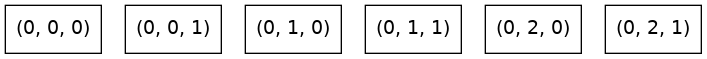

In [4]:
dask_scene.visualize()

In [7]:
dask_scene.dask

HighLevelGraph with 1 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x7f9668fe97c0>
 0. array-c5d4f0cb3f4cbb11c5898cec00b16370

# Initializing Client

After you have generated a task graph, it is the scheduler’s job to execute it.

**If you import Dask, set up a computation, and call compute, then you will use the single-machine scheduler by default. To use the dask.distributed scheduler you must set up a Client.**

https://docs.dask.org/en/latest/deploying.html

In [5]:
from dask.distributed import Client, progress
#client = Client(threads_per_worker=4, n_workers=1)
client = Client()  # Connect to distributed cluster and override default
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/c_galazgarcia@ucsb.edu/proxy/8787/status,
Dashboard: /user/c_galazgarcia@ucsb.edu/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45607,Workers: 4
Dashboard: /user/c_galazgarcia@ucsb.edu/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:33533,Total threads: 1
Dashboard: /user/c_galazgarcia@ucsb.edu/proxy/34483/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:38477,


In [ ]:
client.dashboard_link

In [ ]:
# ??? 
#https://gateway.dask.org

# cluster = dask_gateway.GatewayCluster()
# client = cluster.get_client()
# #cluster.scale(4)
# print(cluster.dashboard_link)

## TEST 0: simplest function
Multiply each element in dask_sceme by 2

In [8]:
%%time
scene*2 

CPU times: user 111 ms, sys: 129 ms, total: 240 ms
Wall time: 213 ms


array([[[ 68,  72,  68, ...,  32,  44,  18],
        [ 68,  76,  76, ...,  38,  42,  34],
        [ 68,  74,  74, ...,  44,  40,  10],
        ...,
        [ 60,  52,  52, ...,  54,  56,  50],
        [ 58,  54,  54, ...,  50,  56,  52],
        [ 66,  62,  52, ...,  54,  60,  62]],

       [[112, 110, 106, ..., 240, 254, 228],
        [108, 116, 112, ..., 254, 252, 234],
        [108, 114, 116, ...,  12, 254, 226],
        ...,
        [ 80,  72,  68, ...,  80,  86,  72],
        [ 78,  72,  74, ...,  80,  88,  78],
        [ 84,  80,  72, ...,  82,  90,  88]],

       [[128, 128, 124, ..., 196, 196, 168],
        [122, 132, 128, ..., 200, 196, 180],
        [124, 128, 132, ..., 212, 204, 182],
        ...,
        [ 98,  92,  90, ..., 116, 112, 104],
        [ 96,  92,  92, ..., 104, 116, 106],
        [106, 100,  92, ..., 106, 116, 118]],

       [[ 50,  52,  50, ...,  46,  74,  70],
        [ 48,  54,  52, ...,  44,  60,  56],
        [ 48,  50,  50, ...,  52,  50,  36],
        ..

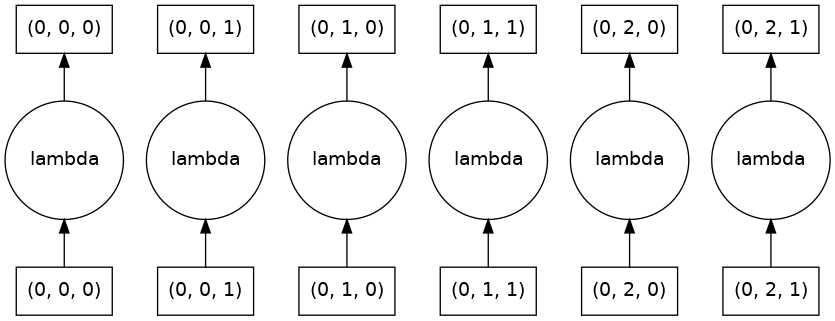

In [6]:
x = dask_scene.map_blocks(lambda x: x*2)
x.visualize()

In [7]:
%%time
y = x.compute()  # ran before initializing DASK cluster (???)
y

CPU times: user 536 ms, sys: 1.38 s, total: 1.92 s
Wall time: 1.91 s


array([[[ 68,  72,  68, ...,  32,  44,  18],
        [ 68,  76,  76, ...,  38,  42,  34],
        [ 68,  74,  74, ...,  44,  40,  10],
        ...,
        [ 60,  52,  52, ...,  54,  56,  50],
        [ 58,  54,  54, ...,  50,  56,  52],
        [ 66,  62,  52, ...,  54,  60,  62]],

       [[112, 110, 106, ..., 240, 254, 228],
        [108, 116, 112, ..., 254, 252, 234],
        [108, 114, 116, ...,  12, 254, 226],
        ...,
        [ 80,  72,  68, ...,  80,  86,  72],
        [ 78,  72,  74, ...,  80,  88,  78],
        [ 84,  80,  72, ...,  82,  90,  88]],

       [[128, 128, 124, ..., 196, 196, 168],
        [122, 132, 128, ..., 200, 196, 180],
        [124, 128, 132, ..., 212, 204, 182],
        ...,
        [ 98,  92,  90, ..., 116, 112, 104],
        [ 96,  92,  92, ..., 104, 116, 106],
        [106, 100,  92, ..., 106, 116, 118]],

       [[ 50,  52,  50, ...,  46,  74,  70],
        [ 48,  54,  52, ...,  44,  60,  56],
        [ 48,  50,  50, ...,  52,  50,  36],
        ..

# GOAL: paralelize the NDVI computation
Before runnin anything through Dask we will try to get the correct task graph

## Test 2: compute ndvi without pandas df

In [9]:
def ndvi(rgbnir):
    x = rgbnir.astype('int16')
    return (x[3,...] - x[0,...])/(x[3,...] + x[0,...])

# ------------------------

def ndvi_thresh(rgbnir, thresh=0.2):
    x = ndvi(rgbnir)
    low_ndvi = x<thresh
    x[low_ndvi]=0
    x[~low_ndvi]=1
    return x

In [11]:
%%time
ndvi0 = ndvi(scene)

CPU times: user 518 ms, sys: 672 ms, total: 1.19 s
Wall time: 1.09 s


<function matplotlib.pyplot.show(close=None, block=None)>

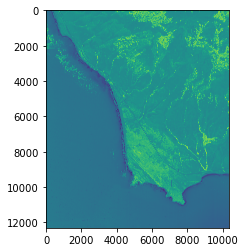

In [12]:
fig, ax = plt.subplots()
ax.imshow(ndvi0)
plt.show

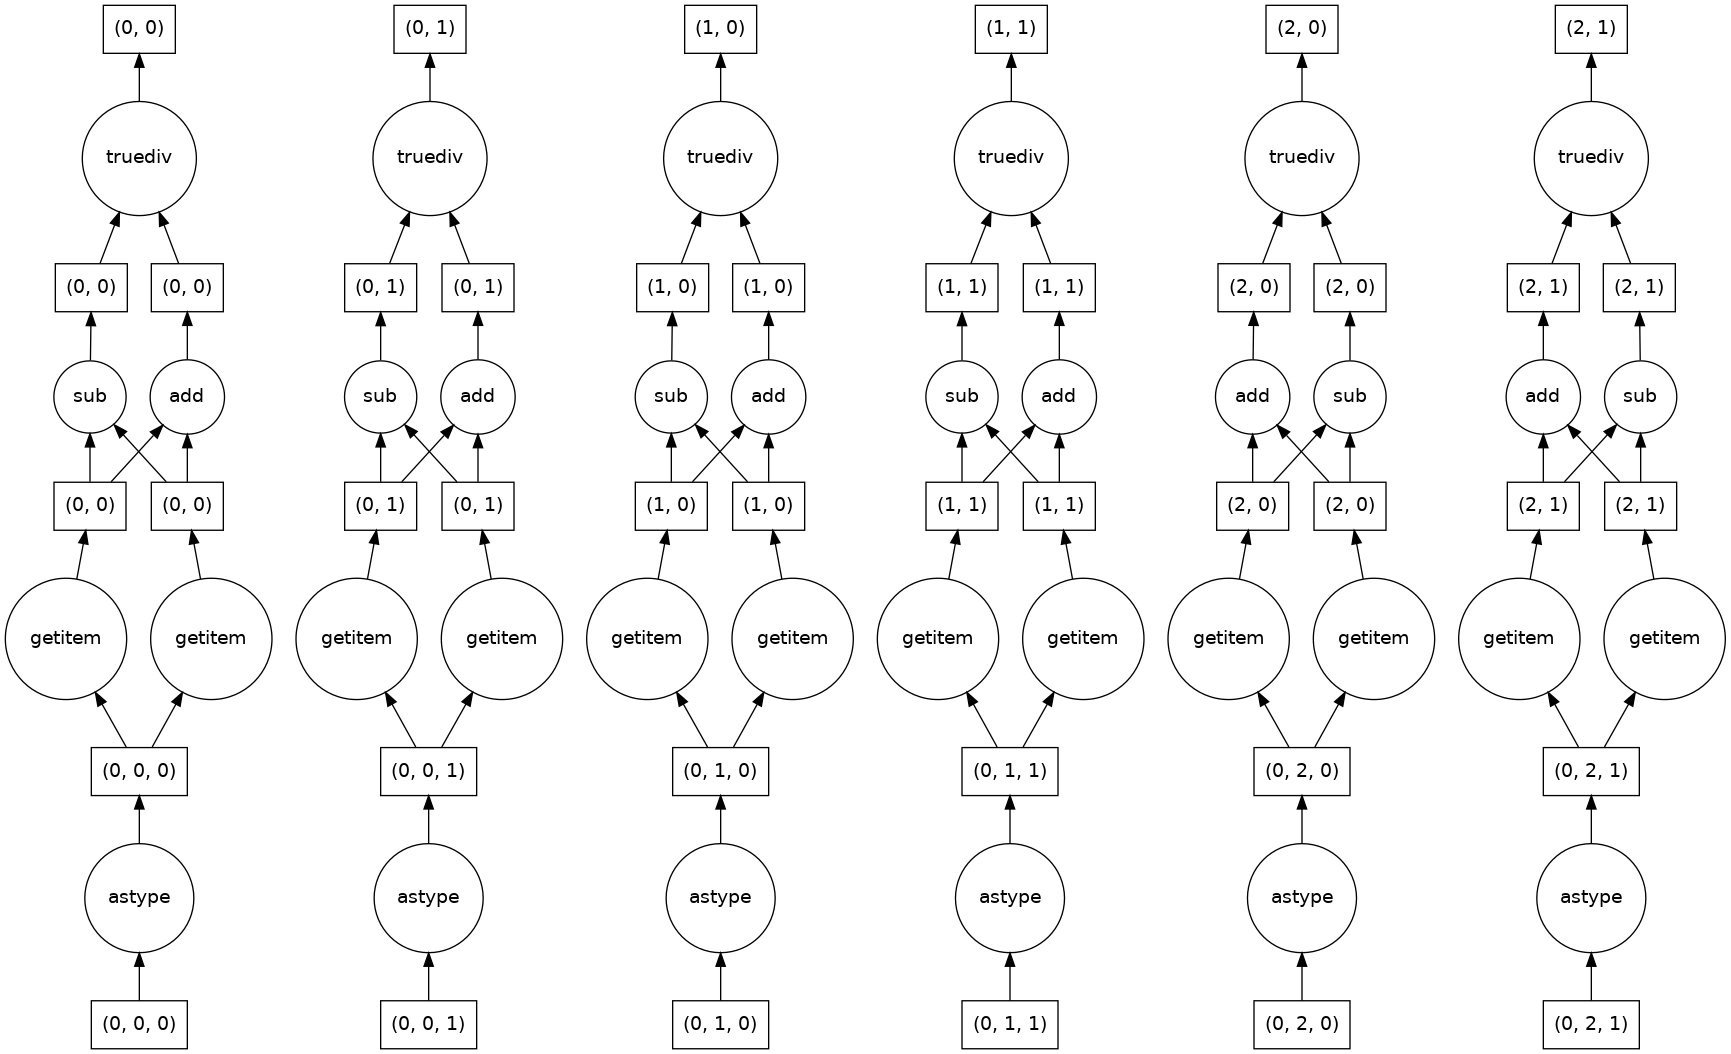

In [17]:
ndvi1 = ndvi(dask_scene)
ndvi1.visualize()

In [23]:
ndvi1

dask.array<truediv, shape=(12310, 10360), dtype=float64, chunksize=(5792, 5180), chunktype=numpy.ndarray>

Compute this dask collection

This turns a lazy Dask collection into its in-memory equivalent. For example a Dask array turns into a NumPy array and a Dask dataframe turns into a Pandas dataframe. The entire dataset must fit into memory before calling this operation.

https://docs.dask.org/en/stable/generated/dask.array.Array.compute.html#dask.array.Array.compute

In [15]:
%%time
ndvi1 = ndvi1.compute()

CPU times: user 1.17 s, sys: 2.3 s, total: 3.46 s
Wall time: 4.52 s


In [51]:
type(ndvi1)

numpy.ndarray

<function matplotlib.pyplot.show(close=None, block=None)>

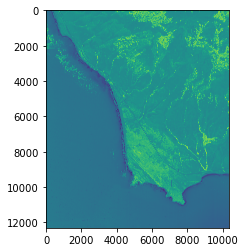

In [20]:
fig, ax = plt.subplots()
ax.imshow(ndvi1)
plt.show

In [ ]:
# def compute_ndvi(image, thresh=0.2):
#     # reshape image into a np.array where each row is a pixel and the columns are the bands
#     pixels = image.reshape([4,-1]).T
#     df = pd.DataFrame(pixels, columns=['r','g','b','nir'])
#     df['ndvi']=(df.nir.astype('int16') - df.r.astype('int16'))/(df.nir.astype('int16') + df.r.astype('int16'))
#     vegetation = df[df.ndvi>thdresh]
#     vegetation.drop(labels=['ndvi'],axis=1, inplace=True)
#     return vegetation